### Notebook by [Volkan Sonmez](http://www.pythonicfool.com/)  
### Node, Edge, and Graph Classifications made with Deep Graph Library
##### [Pythonicfool GitHub Repository](https://github.com/volkansonmez/Exploratory_Data_Analysis_and_ML_Projects)

## Table of contents

1. [Introduction](#Introduction)

2. [EDA and Building ML Model](#EDA_and_Building_ML_Model)

3. [Node_Classification](#Node_Classification)

4. [Edge_Classification](#Edge_Classification)

5. [Graph_Classification](#Graph_Classification)

6. [Conclusion](#Conclusion)

## Introduction

[[ go back to the top ]](#Table-of-contents)

More recently, there has been a steady flow of new deep learning research focusing on graph-structured data. DGL is a tool (library) to do this efficiently. It has tutorials and packages to perform several classifications. This notebook teaches and explores DGL's abilities in node, edge, and graph classifications.

> Learn more about DGL: [dgl.ai](https://docs.dgl.ai/tutorials/blitz/index.html)  

## EDA_and_Building_ML_Model

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python packages that come standard with the Anaconda Python distribution. 
The primary libraries you need to run this notebook are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas matplotlib dgl torch networkx cython


GraphConv and SAGEConv modules are used to build simple neural networks to perform node and edge classifications on CoraDataSet. Additionally, the GraphConv module is used to perform graph classification on MiniGCDataset. For graph classification, the "in" and "out" degrees of edges are multiplied to produce edge connection weights. 

The graphs and subgraph connections are visualized with the networkx library. 


In [1]:
# Import the dgl, torch, networkx, and numpy libraries 

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx

# download the cora graph dataset and store it to a variable
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)
g = dataset[0]
# print(g)

Using backend: pytorch


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [2]:
# View the data

print(len(g.nodes()), g.nodes()) # 2708 nodes, 
print(len(g.edges()[0]), len(g.edges()[1])) # 10556 edges, undirected graph, stored in two arrays as: [from] - [to]
print(g.edges()[0][:5], g.edges()[1][:5], '[from] - [to] edge connections arrays') # view some of the connections

# check in and out degrees to see if this is directed or undirected
print(g.in_degrees()[:5], 'in degrees') 
print(g.out_degrees()[:5], 'out degrees') # it is an undirected graph, all nodes in and out degrees are the same.

2708 tensor([   0,    1,    2,  ..., 2705, 2706, 2707])
10556 10556
tensor([0, 0, 0, 1, 1]) tensor([ 633, 1862, 2582,    2,  652]) [from] - [to] edge connections arrays
tensor([3, 3, 5, 1, 5]) in degrees
tensor([3, 3, 5, 1, 5]) out degrees


In [3]:
# View how a single graph is interpreted with dgl

print(g)

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


It is a graph with 2708 nodes and 10556 edges, each node has an array with 1433 values. 

In [4]:
# View the properties of the nodes and edges of the graph

print(g.ndata) # .ndata outputs node features, node labels, in and out degrees, train, test, validation masks. 
print(g.edata) # .edata outputs attributes. (there is no edge attributes in this dataset)

{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}
{}


In [5]:
# View the ndata property closely for one vertex. 

print(g.ndata['feat'][0][:50]) # view the first 50 values defining the properties of the node sitting at index 0
first_node = g.ndata['feat'][0]
print(len(([i for i in first_node if i > 0]))) # there are only 9 attributes that are not 0 for the first node. 

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
9


Each node has an array with 1433 values. The non-zero values are very sparse. As it is seen above, only 9 values out of 1433 are non-zero in the first node. 

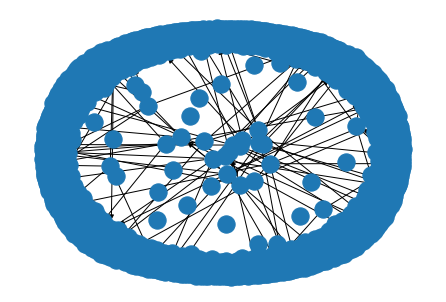

In [6]:
# View some of the random connections

g_from, g_to = g.edges()[0][:100], g.edges()[1][:100] # View the first 100 connections (edges) between nodes
g_view = dgl.graph((g_from, g_to))
nx.draw(g_view.to_networkx()) 

Reminder: nx library is assuming these connections are directed. However, this is an undirected graph. It still serves the purpose for visualization.

## Node_Classification

[[ go back to the top ]](#Table-of-contents)

In [7]:
# Check if the GraphConv module is working for this dataset to perform node classification

from dgl.nn import GraphConv # import GraphConv module
in_feat = g.ndata["feat"].shape[1] # size of the attributes for each node (1433)
out_feat = dataset.num_classes # there are total 7 classes 


class Test_GCN(nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()
        self.conv1 = GraphConv(in_feat, out_feat)

         
    def forward(self, g, in_feat):
        result = self.conv1(g, in_feat)
        return result
    

test_model = Test_GCN(in_feat, out_feat)
logits = test_model(g, g.ndata['feat']) # GraphConv takes the g.ndata['feat'] which is torch.Size([2708, 1433])
pred = logits.argmax(1) # Compute prediction
print(pred[:5])
labels = g.ndata['label']
print(labels[:5])
print(type(pred), pred.shape, (pred == labels).sum()) 

tensor([2, 5, 2, 2, 5])
tensor([3, 4, 4, 0, 3])
<class 'torch.Tensor'> torch.Size([2708]) tensor(358)


It seems like everything is working and our model can be built and trained with this dataset.

In [8]:
# Building a 2 layer NN with GraphConv for Node Classification:

# store node attributes to variables for easy reading / writing
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
 
# define the shape of the in - hidden - out layers
in_feat = g.ndata["feat"].shape[1]
h_feat = 16 # more layers will yield slightly better results (32,50,100..)
out_feat = dataset.num_classes

# create a model with 2 CNN layers with an activation function 
class GCN(nn.Module):
    def __init__(self, in_feat, h_feat, out_feat):
        super().__init__()
        self.conv1 = GraphConv(in_feat, h_feat)
        self.conv2 = GraphConv(h_feat, out_feat)
        
        
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# instantiate the model object and define the optimizer
model = GCN(in_feat, h_feat, out_feat)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 


In [9]:
# train the model with the loss on multi-label cross entropy criterion

for e in range(600):
    # Forward prop
    logits = model(g, features) # GraphConv takes the g.ndata['feat'] which is torch.Size([2708, 1433])

    # Compute predictions
    pred = logits.argmax(1)

    # Compute loss on training data
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Output losses on training, validation, and test sets
    if e % 100 == 99:
        print('At batch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f} '.format(e, loss, val_acc, test_acc))


At batch 99, loss: 1.753, val acc: 0.670, test acc: 0.687 
At batch 199, loss: 1.402, val acc: 0.702, test acc: 0.692 
At batch 299, loss: 1.009, val acc: 0.726, test acc: 0.712 
At batch 399, loss: 0.684, val acc: 0.746, test acc: 0.737 
At batch 499, loss: 0.459, val acc: 0.760, test acc: 0.753 
At batch 599, loss: 0.314, val acc: 0.768, test acc: 0.756 


### About 78% accuracy is achieved with a simple 2 layer model for node classification

## Edge_Classification

[[ go back to the top ]](#Table-of-contents)

To perform Edge Classification, we need both positive and negative connections. We have the positive connections but what about the negative ones?

Since this is an educational notebook it is important to mention the things to do and also not to do:

Here is WHAT NOT TO DO if you have a large sparse positive connections array: Creating a huge negative connection array and build a negative connection matrix and then feed it into the model. DGL claims that they found an optimized way to build negative connection matrix but it is still going to take extra time and space. 

* Here is an example of what a pythonic fool would attempt to do: Building a negative connection matrix out of this data like it is shown in the below cell:

    # Extracting "negative connections" out of the very sparse positive connections list.

    u, v = g.edges()

    # Shuffle the indices, split the data to train and test sets
    shuffled_indices = np.random.permutation(g.number_of_edges())
    test_size = int(len(shuffled_indices) * 0.1)
    train_size = int(len(shuffled_indices) * 0.9)
    test_pos_u, test_pos_v = u[shuffled_indices[:test_size]], v[shuffled_indices[:test_size]]
    train_pos_u, train_pos_v = u[shuffled_indices[test_size:]], v[shuffled_indices[test_size:]]
    print(test_pos_u[:10])


    # reconstruct a graph, 
    # assign the positive and negative edges lists for training and test sets to new variables. 
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())


    # create a matrix of the original positive edge connections
    g_from, g_to = g.edges()[0], g.edges()[1]
    mat = np.zeros([len(g_from), len(g_to)])
    # row and col have the same length so one loop will suffice for creating a matrix.
    for i in range(len(g_from)): 
        row_item_ind = g_from[i]
        col_item_ind = g_to[i]
        mat[row_item_ind][col_item_ind] = 1
    print(mat[:10][:10])

    mat_negative = np.array(mat, dtype = int) - np.ones(mat.shape) # just to view the negative connections with -1
    print(mat_negative[:10][:10]) # View

Since this is a sparse matrix, building a negative connection matrix will be too expensive. No need to extract a node_length.pow(2) long negative connections list to build a matrix as it is seen above

An alternative but not 100% accurate way to build the negative connection 'from' - 'to' arrays for very sparsely connected graph would be just assuming that the negative connections matrix is all made of ones (scalar value). 

> Here is the CoraGraphDataset's properties: NumNodes: 2708, NumEdges: 10556. 

On average, each node is connected to 4 or 5 nodes and but not to the other +2700 (some number between 2700-2708 per node)

This means that there is max 1/540 to min 1/675 chance that two randomly picked two nodes are connected.

In [10]:
# building positive and negative connection arrays (from-to g.edges()) is randomly pick

u, v = g.edges()

# Shuffle the indices, split the data to train and test sets
shuffled_indices = np.random.permutation(g.number_of_edges())
test_size = int(len(shuffled_indices) * 0.1)
train_size = int(len(shuffled_indices) * 0.9)
test_pos_u, test_pos_v = u[shuffled_indices[:test_size]], v[shuffled_indices[:test_size]]
train_pos_u, train_pos_v = u[shuffled_indices[test_size:]], v[shuffled_indices[test_size:]]
print(test_pos_u[:10])


# assign the positive and negative edges lists for training and test sets to new variables. 
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())

u, v = g.edges()
# create two shuffled indices. 
# with around 1/600 error rate, let's make a negative connection list of this dataset with random connection pairs
shuffled_indices = np.random.permutation(g.number_of_edges())
u_neg = u # same nodes
v_neg = v[shuffled_indices] # random nodes that are very unlikely to be the right connections

test_size = int(len(shuffled_indices) * 0.1)
train_size = int(len(shuffled_indices) * 0.9)
test_neg_u, test_neg_v = u_neg[shuffled_indices[:test_size]], v_neg[shuffled_indices[:test_size]]
train_neg_u, train_neg_v = u_neg[shuffled_indices[test_size:]], v_neg[shuffled_indices[test_size:]]


# assign the negative edges lists for training and test sets to new variables. 
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())


# add self connections since there might be 0-in-degree nodes in the graph and backprop will also work on them
train_pos_g = dgl.add_self_loop(train_pos_g)
train_neg_g = dgl.add_self_loop(train_neg_g)

print(u[:30], v[:30], len(u), len(v))
print(u_neg[:30], v_neg[:30], len(u_neg), len(v_neg))

tensor([ 516, 1359, 1270,  960, 2597, 1701, 1904, 1463, 1224, 2079])
tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6,
        7, 8, 8, 8, 9, 9]) tensor([ 633, 1862, 2582,    2,  652,  654,    1, 1986,  332, 1666, 1454, 2544,
        2176, 1016, 1761, 1256, 2175, 1629, 2546, 1659, 1416, 1602, 1042,  373,
         208,  281, 1996,  269, 2614,  723]) 10556 10556
tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6,
        7, 8, 8, 8, 9, 9]) tensor([1483, 1353, 2130, 1013,  118, 1740, 1810,  629, 1892, 1664, 1207, 1671,
        2118, 2570, 1503,   84, 1062,  754,  306,  693,  109, 1638, 1337, 2057,
         654,  879,   10, 1620, 1139, 2531]) 10556 10556


#### Useful info on how to do addition on graphs based on the DGL tutorial:

    Reminder for: Homogeneous Graph for addition:
        g_test = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4]))
        g_test.ndata['h'] = torch.ones(5, 2)
        g_test.apply_edges(lambda edges: {'x' : edges.src['h'] + edges.dst['h']})
        print(g_test.edata['x'])

    Reminder for: Heterogeneous graph for addition:
        g_test = dgl.heterograph({('user', 'plays', 'game'): ([0, 1, 1, 2], [0, 0, 2, 1])})
        g_test.edges[('user', 'plays', 'game')].data['h'] = torch.ones(4, 5)
        g_test.apply_edges(lambda edges: {'h': edges.data['h'] * 2})
        print(g_test.edges[('user', 'plays', 'game')].data['h'])


#### Before creating a model, try using DGL's apply_edges and fn.u_add_V properties:  

#### Examples on DGL's built-in functions:
    g_test = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4])) # create a graph with edges and 5 nodes 0,1..4
    g_test.ndata['h'] = torch.ones(5, 2) # assign node attributes with 'ndata['h']' to those 5 nodes each having 2 attr.


    # Test the addition: u['h'] is added to v['h'] and stored in edata['x']
    import dgl.function as fn
    g_test.apply_edges(fn.u_add_v('h', 'h', 'x'))
    print(g_test.edata['x'], g_test.edata['x'].shape)


    # Test the dot product: u['h'] multiplied with v['h'] and stored in edata['score']
    import dgl.function as fn
    g_test.ndata['h'] = torch.ones(5, 2)
    # Compute a new edge feature named 'score' by a dot-product btwn the src. node feature 'h' and dest. node feature 'h'
    g_test.apply_edges(fn.u_dot_v('h', 'h', 'score'))
    # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
    print(g_test.edata['score'][:, 0], g_test.edata['score'][:, 0].shape) 


In [11]:
# Build a two-layer GraphSAGE model

from dgl.nn import SAGEConv
import dgl.function as fn

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# shuffle the graph nodes and then prepare it for training 

train_g = dgl.remove_edges(g, shuffled_indices[:test_size]) # remove 10 percent (test size) from the original data
train_g = dgl.add_self_loop(train_g)
print(train_g.ndata)
# create the model
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16) # hidden size is picked 16 for convenience


{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}


In [12]:
# Set up the optimizer 
optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.001)

In [13]:
# Train the model for the link (edge) prediction analysis
from sklearn.metrics import roc_auc_score # for calculating accuracy

for e in range(500):
    # forward prop
    h_pos = model(train_pos_g, train_g.ndata['feat']) 
    h_neg = model(train_neg_g, train_g.ndata['feat']) 
    # Compute a new edge feature named 'score' by a dot-product between the
    # source node feature 'h' and destination node feature 'h'. Both for positive and negative connections
    # obtain the positive scores
    train_pos_g.ndata['h'] = h_pos
    train_pos_g.apply_edges(fn.u_dot_v('h', 'h', 'score')) # store the dot product of nodes['h'] in edata['score']
    train_pos_g.edata['score'] = train_pos_g.edata['score'][:, 0] # reshape the array to (1,:)
    pos_score = train_pos_g.edata['score'] # store the scores
    
    # obtain negative scores
    train_neg_g.ndata['h'] = h_neg
    train_neg_g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
    train_neg_g.edata['score'] = train_neg_g.edata['score'][:, 0]
    neg_score = train_neg_g.edata['score']
    
    # calculate the loss between positive scores and negative scores
    scores = torch.cat([pos_score, neg_score]) # put both scores in one array in order
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]) # set up the labels 
    loss = F.binary_cross_entropy_with_logits(scores, labels) # calculate the binary cross entropy loss

    
    # back prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 49 == 0:
        train_scores = np.array(torch.cat([pos_score, neg_score]).detach())
        labels = np.array(torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]))
        acc = roc_auc_score(labels, train_scores)
        print('At batch: {}, training loss : {}, test accuracy: {}'.format(e, loss, acc))
    

At batch: 0, training loss : 0.692885160446167, test accuracy: 0.574600183130675
At batch: 49, training loss : 0.6419017314910889, test accuracy: 0.8574440126434995
At batch: 98, training loss : 0.5201208591461182, test accuracy: 0.9321656236470814
At batch: 147, training loss : 0.4715169668197632, test accuracy: 0.968966071381838
At batch: 196, training loss : 0.44523924589157104, test accuracy: 0.9801350473841413
At batch: 245, training loss : 0.4273204803466797, test accuracy: 0.9852132884948278
At batch: 294, training loss : 0.41393885016441345, test accuracy: 0.9885068887273414
At batch: 343, training loss : 0.4033653438091278, test accuracy: 0.9910012386246821
At batch: 392, training loss : 0.3947652578353882, test accuracy: 0.9927426753315003
At batch: 441, training loss : 0.3875463306903839, test accuracy: 0.994234064542242
At batch: 490, training loss : 0.3812909722328186, test accuracy: 0.9955026369605606


### 99 percent test accuracy is achieved in link prediction (edge classification). 

## Graph_Classification

[[ go back to the top ]](#Table-of-contents)

#### Graph Classification with MiniGCDataset:

Parameters needed to build a sample dataset from MiniGCDataset:
* class dgl.data.MiniGCDataset takes: (num_graphs, min_num_v, max_num_v) to create dgl graphs. 
* num_graphs: number of graphs in this dataset
* min_num_v: minimum number of nodes for graphs
* max_num_v: maximum number of nodes for graphs

In [14]:
from dgl.data import MiniGCDataset

# from res.plot_lib import set_default
# set_default(figsize=(3, 3), dpi=150)

#### Generating artifical graph dataset with DGL:

The datset contains 8 different types of graphs: 
('cycle','star','wheel','lollipop','hypercube','grid','clique','circular ladder')

In [15]:
trainset = MiniGCDataset(600, 10, 15) # create 500 of randomly picked graphs between 8 to 15 nodes for training
testset = MiniGCDataset(150, 10, 15)

# add features to the nodes (in * out degrees to each node) 
# add features to the edges (just add 1 to each edge to represent a simple connection)
def add_features(dataset):
    for (graph, _) in dataset:
        in_degrees = graph.in_degrees() # in degrees to each node
        out_degrees = graph.out_degrees() # in degrees to each node
        in_and_out_degrees = in_degrees * out_degrees  # use the vector multiplication of in and out degrees 
        # graph.ndata['attr'] = in_degrees.view(-1, 1).float() # this is a default approach by most engineers
        graph.ndata['attr'] = in_and_out_degrees.view(-1, 1).float() / 100 
        graph.edata['attr'] = torch.ones(graph.number_of_edges(), 1)
    return dataset


trainset = add_features(trainset)
testset = add_features(testset)

print(len(trainset))
print(trainset[0][0])

600
Graph(num_nodes=14, num_edges=42,
      ndata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)})


In [16]:
# Add features to the nodes (in * out degrees to each node) 
# add features to the edges (just add 1 to each edge to represent a simple connection)

# Ex: [Graph(num_nodes=13, num_edges=57,
#       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
#       edata_schemes={}), tensor([1])]

data: (Graph(num_nodes=14, num_edges=42,
      ndata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}), tensor(0)) label: (Graph(num_nodes=10, num_edges=30,
      ndata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}), tensor(0))
tensor([[0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900],
        [0.0900]]) tensor([[1.2100],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600],
        [0.1600]])


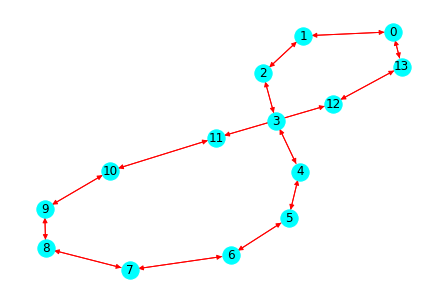

In [17]:
# Visualize a randomly picked graph

print('data:', trainset[0], 'label:', trainset[1])
# print(trainset[0][0].ndata['feat'], trainset[0][0].edata['feat']) 
plt.figure()
nx.draw(trainset[0][0].to_networkx(), with_labels=True, node_color='cyan', edge_color='red')
print(trainset[0][0].ndata['attr'] , trainset[200][0].ndata['attr'])

In [18]:
# Consolidate a few graphs into each batch. For simplicity, the solution below is made for 1 graph ==> 1 batch
# It is common to pick a number between 5-20 graphs for a batch. 

from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

print(len(trainset), len(testset))
num_examples = len(trainset)
num_train = int(num_examples * 0.8)
num_test = len(testset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_test))

train_dataloader = GraphDataLoader(
    trainset, sampler=train_sampler, batch_size=10, drop_last=False)
test_dataloader = GraphDataLoader(
    testset, sampler=test_sampler, batch_size=10, drop_last=False)


600 150


In [19]:
# Check if the trainloader iterable object is working

it = iter(train_dataloader)
batch = next(it)
print(batch)
print(it.next())

[Graph(num_nodes=103, num_edges=505,
      ndata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}), tensor([3, 4, 6, 4, 3, 5, 1, 5, 5, 1])]
[Graph(num_nodes=109, num_edges=591,
      ndata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'attr': Scheme(shape=(1,), dtype=torch.float32)}), tensor([2, 6, 5, 0, 1, 6, 2, 1, 3, 4])]


In [20]:
# Review the properties of each batch

batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())
print('Node feature dimensionality:', trainset.max_num_v)
print('Number of graph categories:', trainset.num_classes)

Number of nodes for each graph element in the batch: tensor([10,  8, 10,  8, 12,  9, 12, 12, 12, 10])
Number of edges for each graph element in the batch: tensor([ 48,  32, 100,  32, 106,  33,  34,  46,  46,  28])
Node feature dimensionality: 15
Number of graph categories: 8


In [21]:
# Build a 2 layer NN with GraphConv

from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')


# Create the model with given dimensions
model = GCN(1, 16, trainset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Train the model: 

for batch in range(1000):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if batch % 100 == 99:
        # testing
        num_correct = 0
        num_tests = 0
        for batched_graph, labels in test_dataloader:
            pred = model(batched_graph, batched_graph.ndata['attr'].float())
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        print('at:', batch, 'Test accuracy %:', num_correct / num_tests * 100)
        

at: 99 Test accuracy %: 63.33333333333333
at: 199 Test accuracy %: 66.66666666666666
at: 299 Test accuracy %: 67.33333333333333
at: 399 Test accuracy %: 67.33333333333333
at: 499 Test accuracy %: 71.33333333333334
at: 599 Test accuracy %: 71.33333333333334
at: 699 Test accuracy %: 71.33333333333334
at: 799 Test accuracy %: 74.0
at: 899 Test accuracy %: 75.33333333333333
at: 999 Test accuracy %: 74.0


## Conclusion

[[ go back to the top ]](#Table-of-contents)

Dgl library seems like a fast tool for graph analysis and categorization of nodes, edges, and patterns. However, it is hard to reach good accuracy sometimes due to the module selection in the architecture of the models. 

The model made for edge classification has an impressive accuracy with the CoraGraphDataset. However, the models made for node or graph classifications didn't perform as accurately as the model made for the edge classification.